# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [15]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [3e-10, 1e-9, 5e-9, 1e-8]
regularization_strengths = [5e4, 5e5, 5e6, 2e7]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#divide training into folds
num_training = X_train_feats.shape[0]

print("num_training: ", num_training)

folds = []
folds_label = []
num_folds = 1
num_data_per_fold = num_training / num_folds

for i in range(num_folds):
    folds.append(X_train_feats[int(i*num_data_per_fold):int((i+1)*num_data_per_fold),:])
    folds_label.append(y_train[int(i*num_data_per_fold):int((i+1)*num_data_per_fold)])
    
parameters = [ (l,r) for l in learning_rates for r in regularization_strengths ]

from functools import reduce

for (l,r) in parameters:
    
    accuracies = []
    
    print("l,r:", l,r)
    
    svm_temp = LinearSVM()
    
    for i in range(num_folds):
        
        svm_temp = LinearSVM()
        
        #training_set = [folds[j] for j in range(num_folds) if j != i]
        #training_label = [folds_label[j] for j in range(num_folds) if j != i]
        
        training_set = [folds[j] for j in range(num_folds)]
        training_label = [folds_label[j] for j in range(num_folds)]
        
        t_set = np.concatenate(training_set)
        t_label_set = np.concatenate(training_label)
        #v_set = folds[i]
        #v_label = folds_label[i]
        v_set = X_val_feats
        v_label = y_val
        
        svm_temp.train(t_set, t_label_set, l, r, num_iters=4500, verbose=True)
        
        pred_train = svm_temp.predict(t_set)
        pred_validate = svm_temp.predict(v_set)
        
        accuracy_train = np.mean(pred_train == t_label_set)
        accuracy_validation = np.mean(pred_validate == v_label)
        
        accuracies.append((accuracy_train,accuracy_validation))

    print(accuracies)

    accuracy = reduce(lambda a,b: (a[0]+b[0],a[1]+b[1]), accuracies, (0,0))
    
    f = 1.0/len(accuracies)

    results[l,r] = (accuracy[0]*f, accuracy[1]*f)
    if accuracy[1]*f > best_val:
        best_svm = svm_temp
    best_val = max(best_val,accuracy[1]*f)
    print('validation accuracy: %f' % (accuracy[1]*f))    

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

num_training:  49000
l,r: 3e-10 50000.0
iteration 0 / 4500: loss 88.843594
iteration 100 / 4500: loss 88.370642
iteration 200 / 4500: loss 87.895347
iteration 300 / 4500: loss 87.416570
iteration 400 / 4500: loss 86.963177
iteration 500 / 4500: loss 86.499823
iteration 600 / 4500: loss 86.031889
iteration 700 / 4500: loss 85.568109
iteration 800 / 4500: loss 85.109232
iteration 900 / 4500: loss 84.650785
iteration 1000 / 4500: loss 84.189548
iteration 1100 / 4500: loss 83.730004
iteration 1200 / 4500: loss 83.293195
iteration 1300 / 4500: loss 82.859421
iteration 1400 / 4500: loss 82.408702
iteration 1500 / 4500: loss 81.976643
iteration 1600 / 4500: loss 81.533213
iteration 1700 / 4500: loss 81.088534
iteration 1800 / 4500: loss 80.670986
iteration 1900 / 4500: loss 80.234096
iteration 2000 / 4500: loss 79.806710
iteration 2100 / 4500: loss 79.396332
iteration 2200 / 4500: loss 78.966746
iteration 2300 / 4500: loss 78.540643
iteration 2400 / 4500: loss 78.132605
iteration 2500 / 4500:

iteration 2900 / 4500: loss 50.648359
iteration 3000 / 4500: loss 49.827305
iteration 3100 / 4500: loss 49.018830
iteration 3200 / 4500: loss 48.223653
iteration 3300 / 4500: loss 47.446341
iteration 3400 / 4500: loss 46.693272
iteration 3500 / 4500: loss 45.943140
iteration 3600 / 4500: loss 45.213490
iteration 3700 / 4500: loss 44.498855
iteration 3800 / 4500: loss 43.786265
iteration 3900 / 4500: loss 43.102729
iteration 4000 / 4500: loss 42.439927
iteration 4100 / 4500: loss 41.774765
iteration 4200 / 4500: loss 41.108655
iteration 4300 / 4500: loss 40.486186
iteration 4400 / 4500: loss 39.857433
[(0.09075510204081633, 0.093)]
validation accuracy: 0.093000
l,r: 1e-09 500000.0
iteration 0 / 4500: loss 745.387009
iteration 100 / 4500: loss 611.845208
iteration 200 / 4500: loss 502.511673
iteration 300 / 4500: loss 413.020128
iteration 400 / 4500: loss 339.750068
iteration 500 / 4500: loss 279.768165
iteration 600 / 4500: loss 230.667363
iteration 700 / 4500: loss 190.461392
iteration

iteration 1300 / 4500: loss 9.001698
iteration 1400 / 4500: loss 9.000608
iteration 1500 / 4500: loss 9.000210
iteration 1600 / 4500: loss 9.000043
iteration 1700 / 4500: loss 8.999986
iteration 1800 / 4500: loss 8.999974
iteration 1900 / 4500: loss 8.999969
iteration 2000 / 4500: loss 8.999970
iteration 2100 / 4500: loss 8.999970
iteration 2200 / 4500: loss 8.999959
iteration 2300 / 4500: loss 8.999964
iteration 2400 / 4500: loss 8.999973
iteration 2500 / 4500: loss 8.999969
iteration 2600 / 4500: loss 8.999960
iteration 2700 / 4500: loss 8.999960
iteration 2800 / 4500: loss 8.999970
iteration 2900 / 4500: loss 8.999961
iteration 3000 / 4500: loss 8.999964
iteration 3100 / 4500: loss 8.999960
iteration 3200 / 4500: loss 8.999973
iteration 3300 / 4500: loss 8.999965
iteration 3400 / 4500: loss 8.999968
iteration 3500 / 4500: loss 8.999963
iteration 3600 / 4500: loss 8.999967
iteration 3700 / 4500: loss 8.999954
iteration 3800 / 4500: loss 8.999969
iteration 3900 / 4500: loss 8.999959
i

iteration 100 / 4500: loss 9.000002
iteration 200 / 4500: loss 8.999996
iteration 300 / 4500: loss 8.999997
iteration 400 / 4500: loss 8.999997
iteration 500 / 4500: loss 8.999997
iteration 600 / 4500: loss 8.999997
iteration 700 / 4500: loss 8.999997
iteration 800 / 4500: loss 8.999996
iteration 900 / 4500: loss 8.999997
iteration 1000 / 4500: loss 8.999997
iteration 1100 / 4500: loss 8.999997
iteration 1200 / 4500: loss 8.999996
iteration 1300 / 4500: loss 8.999996
iteration 1400 / 4500: loss 8.999997
iteration 1500 / 4500: loss 8.999996
iteration 1600 / 4500: loss 8.999997
iteration 1700 / 4500: loss 8.999997
iteration 1800 / 4500: loss 8.999996
iteration 1900 / 4500: loss 8.999997
iteration 2000 / 4500: loss 8.999997
iteration 2100 / 4500: loss 8.999997
iteration 2200 / 4500: loss 8.999997
iteration 2300 / 4500: loss 8.999997
iteration 2400 / 4500: loss 8.999996
iteration 2500 / 4500: loss 8.999997
iteration 2600 / 4500: loss 8.999997
iteration 2700 / 4500: loss 8.999996
iteration 

In [16]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.416


In [4]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

NameError: name 'y_test_pred' is not defined

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [5]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


154
0.05 5e-06 200
iteration 0 / 30000: loss 2.302588
iteration 100 / 30000: loss 2.301480
iteration 200 / 30000: loss 2.276173
iteration 300 / 30000: loss 2.063783
iteration 400 / 30000: loss 1.860829
iteration 500 / 30000: loss 1.718849
iteration 600 / 30000: loss 1.573274
iteration 700 / 30000: loss 1.525285
iteration 800 / 30000: loss 1.448204
iteration 900 / 30000: loss 1.459818
iteration 1000 / 30000: loss 1.409485
iteration 1100 / 30000: loss 1.370081
iteration 1200 / 30000: loss 1.374428
iteration 1300 / 30000: loss 1.403306
iteration 1400 / 30000: loss 1.368267
iteration 1500 / 30000: loss 1.334373
iteration 1600 / 30000: loss 1.332256
iteration 1700 / 30000: loss 1.329996
iteration 1800 / 30000: loss 1.336250
iteration 1900 / 30000: loss 1.305707
iteration 2000 / 30000: loss 1.310997
iteration 2100 / 30000: loss 1.333660
iteration 2200 / 30000: loss 1.293875
iteration 2300 / 30000: loss 1.286949
iteration 2400 / 30000: loss 1.294064
iteration 2500 / 30000: loss 1.270053
itera

iteration 21300 / 30000: loss 0.602427
iteration 21400 / 30000: loss 0.613858
iteration 21500 / 30000: loss 0.556964
iteration 21600 / 30000: loss 0.599847
iteration 21700 / 30000: loss 0.553780
iteration 21800 / 30000: loss 0.598357
iteration 21900 / 30000: loss 0.567436
iteration 22000 / 30000: loss 0.551197
iteration 22100 / 30000: loss 0.556502
iteration 22200 / 30000: loss 0.556410
iteration 22300 / 30000: loss 0.590791
iteration 22400 / 30000: loss 0.611436
iteration 22500 / 30000: loss 0.570931
iteration 22600 / 30000: loss 0.601677
iteration 22700 / 30000: loss 0.582553
iteration 22800 / 30000: loss 0.575852
iteration 22900 / 30000: loss 0.538809
iteration 23000 / 30000: loss 0.555250
iteration 23100 / 30000: loss 0.561473
iteration 23200 / 30000: loss 0.589861
iteration 23300 / 30000: loss 0.588577
iteration 23400 / 30000: loss 0.593174
iteration 23500 / 30000: loss 0.550636
iteration 23600 / 30000: loss 0.577891
iteration 23700 / 30000: loss 0.551559
iteration 23800 / 30000: 

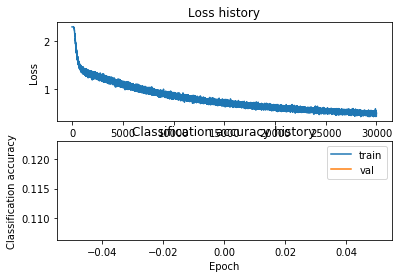

Validation accuracy:  0.58
best validation accuracy:  0.58
param:  (0.05, 5e-06, 200)


In [13]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]

print(input_dim)

num_classes = 10

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = [5e-2]
regularization_strengths = [5e-6]
hidden_sizes = [200]

parameters = [ (l,r,h) for l in learning_rates for r in regularization_strengths for h in hidden_sizes]
700
best_accuracy = 0.0

param = None

for (l,r,h) in parameters:
    
    print(l,r,h)
    
    #print(X_train_feats.shape)
    #print(y_train.shape)
    #print(X_val_feats.shape)
    #print(y_val.shape)
    
    #Train the network
    curr_net = TwoLayerNet(input_dim, h, num_classes,std=1e-3)
    stats = curr_net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=30000, batch_size=1250,
                learning_rate=l, learning_rate_decay=0.99,
                reg=r, verbose=True)

    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Classification accuracy')
    plt.legend()
    plt.show()
    
    #Predict on the validation set
    val_acc = (curr_net.predict(X_val_feats) == y_val).mean()
    print('Validation accuracy: ', val_acc)

    if val_acc > best_accuracy:
        best_net = curr_net
        best_accuracy = val_acc
        param = (l,r,h)

print('best validation accuracy: ', best_accuracy)
print('param: ', param)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [14]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.57
